# Stable diffusion 실습(2)
\
Stable diffusion 모델은 1024x1024 크기의 이미지를 생성할 수 있으며, 다양한 스타일과 질감을 표현할 수 있습니다.
이를 위해 SD 모델이 활용하는 파라미터수는 약 23억 개 입니다. ['With 860 millions of parameters in the U-Net and 123 millions in the text encoder'](https://en.wikipedia.org/wiki/Stable_Diffusion)

이렇게 커다란 모델이다보니 파라미터 전체를 한꺼번에 학습하기 위해서는 여전히 높은 하드웨어 사양을 요구합니다. 따라서 파라미터를 일부분만 갱신하더라도 더 가볍고 효과적으로 미세조정하는 방법이 다양하게 개발되고있습니다.

> - Fine tuning, Textual Inversion, **DreamBooth**, LoRA, ...

[What are we fine-tuning?](https://keras.io/examples/generative/finetune_stable_diffusion/#data-loading)

모델의 모든 파라미터를 Fine-tuning 에 참여시키는 것은 이미지의 특성이 수정되는 효과에 비해 과도한 연산량을 소모합니다.
때문에 여러 경로를 통해 모델의 일부분만 가지고 우리가 주입하고 싶은 데이터를 스며들도록 하는 것이 포인트입니다.

Huggingface - diffusers API 를 활용해 미세조정 작업을 수행해볼까요?

> 1. 먼저 Huggingface 에 로그인
> 2. 우측 상단의 Settings로 이동
> 3. Access Token 페이지에서 New Token을 Read로 발급
> 4. API key 를 복사

해당 코드에 API key 를 넣고 실행해주세요

In [ ]:
!mkdir -p ~/.huggingface
HUGGINGFACE_TOKEN = # [Your Code]
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token

아래 링크의 레포지토리를 복사해와야 합니다.\
코드블럭을 실행시키면 diffusers를 clone해옵니다.

In [ ]:
!git clone https://github.com/huggingface/diffusers ~/diffusers_git

아래 명령어를 터미널에 입력하여 버전을 고정시켜주어야 합니다.\
저희는 Diffusers 0.22.0 버전을 사용하도록 하겠습니다.\
다른 버전을 이용하고 싶으시다면 git tags 명령어를 통해 이용 가능한 버전을 확인하세요

In [ ]:
!cd diffusers_git && git checkout tags/v0.22.0

자 이제 diffusers를 설치해볼까요?

In [ ]:
!pip install -e ~/diffusers_git

In [ ]:
!pip list | grep diffusers

설치가 잘 되었다면 위의 결과에서 `diffusers 0.22.0 /aiffel/diffusers_git` 이라는 결과가 보일겁니다.\
이제 diffusers가 준비되었습니다!

Stable diffusion 원본을 그대로 활용하는 것은 적절한 하드웨어를 갖추지 않은 이상 쉽지않습니다\

오늘은 실습을 위해 12 GB GPU에서도 구동할 수 있는 가벼운 모델을 불러와 학습시켜보겠습니다.\

먼저 몇가지 의존성 모듈을 설치해줘야합니다.

In [ ]:
!pip install -r ~/diffusers_git/examples/dreambooth/requirements.txt
!pip uninstall -y bitsandbytes
!pip install bitsandbytes==0.41.1
!pip install xformers==0.0.20
!pip install accelerate==0.24.1
!pip install triton==2.0.0

Accelerate 모듈을 활용하기 위해서 configuration 을 초기화해줍니다

In [ ]:
!accelerate config default

Dreambooth 방식으로 미세조정을 수행하기 위해서는 몇 가지 종류의 데이터를 준비해야합니다.

> - Unique class: 학습 시키려는 예시를 포괄하는 dog, person 등의 중간 카테고리로 클래스를 설정해줍니다. 우리는 dog 를 사용하도록 하겠습니다.
> - Unique identifier: 학습 시키고싶은 특정한 대상을 위해, 이전 어휘와 겹치지않는 유일한 단어를 identifier, ID 로 설정해줍니다. 이때 아무 의미를 지니지 않은 무작위의 단어 조합을 선택하도록합니다. 이 예시에서는 **sks** 와 같이 최대한 아무 의미를 가지지 않는 단어를 사용했습니다.
> - Class prompt: 특정한 ID 를 제외하고 이미지에 대한 설명을 넣어주도록 합니다. "a photo of dog".
> - Instance prompt: 학습시킬 대상 이미지들이 표기되어있는 설명 문장을 입력합니다. 예시로 다음과 같은 형식을 사용할 수 있습니다 - f"a photo of {unique_id} {unique_class}". 예제에서 사용할 ID 와 클래스를 조합하면 "a photo of sks dog" 와 같은 문장을 만들 수 있습니다.
> - Class images: class prompt 에 맞추어 학습시킬 대상을 포함하는 넓은 범위의 이미지를 모읍니다. 일반적으로 200-300 장 정도면 충분합니다.
> - Instance images: instance prompt 와 연결하여 학습할 수 있는 이미지를 모읍니다. 학습시키고싶은 동일한 대상으로 3 - 5 장 만 마련하면 됩니다.

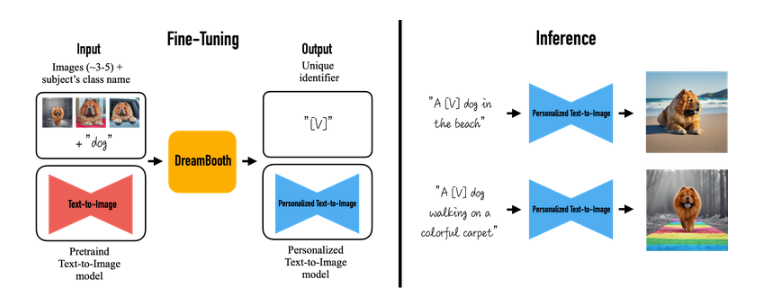

---
예제 튜토리얼을 따라 사용할 이미지 데이터를 불러오겠습니다.\
dreambooth 를 위해서는 5 장 정도의 instance 이미지만 있으면 충분합니다! 놀랍지않나요?\
나중에 SD 모델에 적용하고싶은 대상있다면, 대상의 모습이 담긴 이미지를 모아 아래처럼 경로를 만들어 저장해줍니다.

In [ ]:
from huggingface_hub import snapshot_download

local_dir = "./diffusers_git/examples/dreambooth/dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

SD 모델의 학습 코드에는 여러 종류의 인자들이 입력되어야합니다.\
각 조건들을 좀더 편리하게 입력하기 위해 아래와 같이 셸 스크립트 shell script를 구성해주어야합니다. CLI 터미널에서 sh 명령어로 해당 스크립트를 실행할 수 있습니다.

> Ipython 의 다양한 매직 커맨드 `%`, `%%`를 활용하면 유용한 작업을 쉽게 실행할 수 있습니다
`%%writefile {file_path}` 커맨드는 셀 안의 내용을 텍스트 파일로 저장해줍니다

셸 스크립트 내의 외부환경변수 MODEL_NAME 은 Huggingface 에 등록된 여러 사전학습 모델들을 이름으로 쉽게 불러올 수 있습니다.\
INSTANCE_DIR 에는 학습시키고 싶은 특정 대상의 이미지를 5-6 장 정도 넣어줍니다.\
CLASS_DIR은 학습시키고 싶은 대상과 닮은 참고 이미지들을 넣어줍니다. 여유가 된다면 200 - 300 장 정도 채워줄 수 있습니다. 빠른 진행을 위해 over-fitting 을 감수하고 이번에는 인스턴스와 동일하게 입력하도록 합니다.\
OUTPUT_DIR 경로에는 학습을 통해 만들어진 파라미터, 출력 결과 등이 저장됩니다.

다만, 이번 노드에서는 입력해야하는 텍스트가 많아 data 폴더 안에 셸 스크립트를 미리 준비해놓았습니다. 구성 내용은 아래와 같습니다.

```
export MODEL_NAME="CompVis/stable-diffusion-v1-4"
export INSTANCE_DIR="./diffusers_git/examples/dreambooth/dog"
export CLASS_DIR="./diffusers_git/examples/dreambooth/dog"
export OUTPUT_DIR="./diffusers_git/examples/dreambooth/data"

echo $MODEL_NAME

accelerate launch /aiffel/diffusers_git/examples/dreambooth/train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks dog" \
  --class_prompt="a photo of dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --gradient_accumulation_steps=1 --gradient_checkpointing \
  --use_8bit_adam \
  --enable_xformers_memory_efficient_attention \
  --set_grads_to_none \
  --learning_rate=2e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=5 \
  --max_train_steps=100 \
```

In [ ]:
%reset -f

!sh ~/data/train_dreambooth.sh

print('----'*64)
print('학습 완료!!')

학습이 완료되었습니다! data 경로에 학습된 결과물이 저장되었는지 확인할 수 있겠네요.\
그럼 이제 모델의 출력물을 확인해봐야겠죠? 추론 과정을 위해 별도의 파이프라인을 만들고 학습된 파라미터들을 불러와 생성작업에 활용해보겠습니다.

---

### Inference with ckeckpoints

SD 모델이 이미 묵직하게 메모리를 차지하고 있고, 의존성 문제도 해결해야하기 때문에 `%reset` 매직 커맨드로 커널을 한번 초기화해주겠습니다.\
추론 과정 중 주요 함수에서 버전 문제가 발생하기때문에 부득이 diffusers 모듈도 재설치 해줍니다.

추론을 위한 새로운 파이프라인을 구성해주겠습니다.\
학습을 통해 저장된 체크포인트 가중치를 불러와 추론과정에 사용합니다.

In [ ]:
%reset -f

# 의존성 모듈을 삭제 후 다시 설치합니다.

!pip uninstall -y diffusers
!pip install diffusers==0.22.0

from diffusers import DiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel
import torch

# huggingface에 미리 등록된 base 모델을 다운로드하여 사용합니다.
model_id = "CompVis/stable-diffusion-v1-4"

# 앞서 학습 코드로 만들어진 파라미터들을 로드합니다.
unet = UNet2DConditionModel.from_pretrained("./diffusers_git/examples/dreambooth/data/unet")
text_encoder = CLIPTextModel.from_pretrained("./diffusers_git/examples/dreambooth/data/text_encoder")

# stable diffusion 의 전체 파이프라인을 구성해줍니다.
pipeline = DiffusionPipeline.from_pretrained(model_id, unet=unet, text_encoder=text_encoder, dtype=torch.float16)
pipeline.to("cuda")

모델에 입력할 텍스트 프롬프트를 설정하고, INSTANCE, CLASS 정보도 꼼꼼하게 추가해줍니다.\
inference step, guidence_scale 인자를 조정하여 출력물의 퀄리티를 높여봅시다.

In [ ]:
prompt = "A photo of sks dog chasing a car"
image = pipeline(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

image.save("dog-bucket.png")
image

### Dreambooth 를 사용할 때 주의할 점

>- 드림부스는 상당히 빠르게 과적합하는 경향이 있습니다. 양질의 이미지를 생성하려면 훈련의 스텝 수와 학습률 사이의 '스윗 스팟'을 찾아야 합니다. 낮은 학습률을 먼저 사용하고, 결과가 만족스러울 때까지 단계의 수를 점진적으로 늘리는 것이 좋습니다.
>- 드림부스로 얼굴을 학습하기 위해서는 보통 더 많은 훈련 단계가 필요합니다. 실험에서, 800-1200 스텝으로 배치 사이즈 2 와 1e-6의 학습률을 사용할 때 잘 작동했다는 기록이 있습니다.
>- 얼굴을 훈련할 때 과적합을 피하기 위해 Class image 를 활용한 사전 보존 prior_preservationpreservation 이 중요합니다. 다른 종류의 형상의 경우, 큰 차이를 보이지는 않습니다.
>- 생성된 이미지에 노이즈가 많거나 품질이 저하된다면, 과적합이 발생했다는 의미일 가능성이 높습니다. 과적합을 피하기 위해 더 많은 추론 스텝을 실행해보세요(~100 스텝까지는 실험에서 잘 작동했습니다).
>- Unet 에 더해줄 텍스트 인코더를 학습시키는 것이 생성 결과물을 크게 향상 시킬 수 있습니다. 하지만 텍스트 인코더를 미세조정하기 위해서는 24 GB 이상의 GPU 메모리를 안정적으로 확보할 수 있어야합니다. 메모리가 상대적으로 부족한 시스템이라면 8-bit adam, fp16(float-point 16) 학습, 그래디언트 축적 등의 기법을 추가하여 16 GB 정도의 GPU로도 학습이 가능할 수 있습니다.
>- Dreambooth 의 초기 구현 방법에서 알려진 것과는 다르게, 프롬프트로 sks 와 같이 고유한 키워드를 꼭 설정해줄 필요는 없다는 것이 밝혀졌습니다. 타겟 대상을 가리키는 평이한 단어만으로도 미세조정을 충분히 수행할 수 있다고 알려졌습니다.

dreambooth 를 좀더 최적화하기 위해서 learning rate, prior-preservation, scheduler 등 모델에서 활용하고있는 여러 조건들의 영향을 실험해볼 수 있습니다.\
궁금하신 분들은 [참고자료](https://huggingface.co/blog/dreambooth)를 확인하세요

---
# Stable diffusion 실습(3)

## 나만의 취향, 한 숫갈 듬뿍

무궁무진한 가능성을 담고 있는 stable diffusion 안에서 우리가 원하는 방향으로 이미지를 바꿀 수 있는 가능성을 엿보았습니다.\
더 뛰어난 수준의 이미지를 만들기 위해서는 어떤 것들이 필요한지 알아봅시다.

Stable diffusion 과 함께 폭발적으로 성장하고 있는 사이트를 알고 계신가요?

- [CIVITai.com](https://civitai.com/)

SD 모델의 구현 코드들이 인터넷에 공개 된 이후, 여러 사람들이 모델을 이모양 저모양으로 뜯어보면서 아주 다양한 시도들을 수행해왔습니다.\
위 사이트는 저작권 문제 등 여러 논란의 중심이기도 하면서, 동시에 정말 많은 사람들의 호기심과 노력이 결집된 곳이기도 합니다.\
사이트 페이지를 둘러보다 보면 자주 마주치는 단어들이 있는 것 같습니다.

- CHECKPOINT
- LORA

바로 이 두 가지 개념을 조합하여 우리도 마음껏 나만의 상상을 이미지로 만들어볼 수 있답니다.\
checkpoint는 간단하게 말해 미세조정을 거쳐 저장한 SD 모델의 파라미터(가중치) 입니다.\
우리도 앞 페이지에서 학습해봤듯이, 개인 작업자들이 각자 데이터를 마련하여 본인의 방향성에 맞춰 생성 모델의 가중치들을 업데이트하여 웹 상에 공개할 수 있습니다.\
사이트에 공유된 가중치를 그대로 다운로드받아 모델 파이프라인을 구성하여 탑재할 수 있습니다.

다른 한 가지, 생소하기도한 LoRA 는 무엇일까요?

---

### Lora

Stable diffusion 이 아주 복잡하고 큰 시스템인 만큼, 데이터셋, text inversion, dreambooth 등 전체 모델의 일부분을 통해 미세 조정하는 방식은 아주 다양하게 개발되었습니다.\
하지만 여전히 SD 모델의 큰 덩치(파라미터)는 많은 연산량을 요구하기 떄문에, 디바이스 수준의 다양한 지점에서 활용하는데 자주 걸림돌로 작용합니다.

이와 비슷한 문제를 동시에 겪고 있던 대규모 자연어 모델 Large Language Model, LLM 분야에서 한 가지 특별한 아이디어가 제안됩니다.\
바로 Low Rank Adaptation 간단하게 [LoRA](https://github.com/microsoft/LoRA) 라고 불리는 미세 조정 기법입니다.\
기존의 over-parameter model 내부에서 본질적인 의미를 담고 있는 파라미터의 rank가 낮다(전체가 아닌 일부이다)고 주장하는 연구 결과에서 영감을 받은 LoRA는, 대규모 모델의 파라미터를 저차원 공간으로 투영하는 방식을 활용합니다. 

<br>

$$
h = W_0 x + \delta W x = W_0 x + BAx 
$$

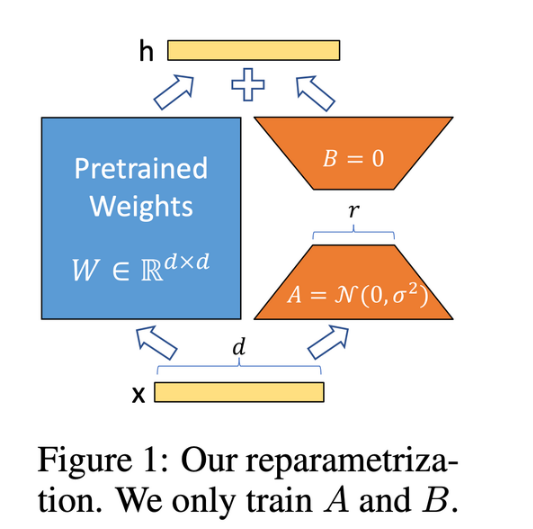

학습 시 pretrained model의 initialized weight인 $W_0$는 동결시켜 가중치 업데이트를 하지 않고, 길이 $r$ 만큼의 low rank를 형성하는 행렬 $A$ 와 $B$ 를 업데이트합니다.\
저차원 공간으로 투영된 파라미터는 특정 작업에 더 적합하도록 부분적으로 학습될 수 있습니다.\
전체 파라미터 중 일부분에만 추가적으로 높은 가중치를 두어, 활용하고자 하는 문제에 알맞는 부분만 따로 활성화 하는 방식이라고 이해할 수 있을 것 같습니다.\
LoRA는 대규모 언어 모델의 파라미터 수를 줄여서 학습 속도를 높이고, 과적합을 방지하는 역할을 한다고 알려져있습니다.

Stable diffusion도 모델의 가중치를 전부 업데이트하는 일반적인 미세 조정 방식은 생각보다 훨씬 많은 컴퓨터 연산량을 필요로 하며 결과에 비해 효율적이지 못한 것으로 보입니다.\
때문에 SD 모델 내부의 일부분만을 강조하여 우리가 원하는 이미지 특성만 강조하여 활용하는 방식인 LoRA 가 대중화되었고,\
다양한 LoRA 가중치들을 선택하여 파이프라인에 넣고 활용할 수 있습니다.


---

### Checkpoint 에 LoRA 덧칠하기

이제 직접 CHECKPOINT 와 LORA 를 적용하여 다양한 이미지를 생성해보겠습니다.

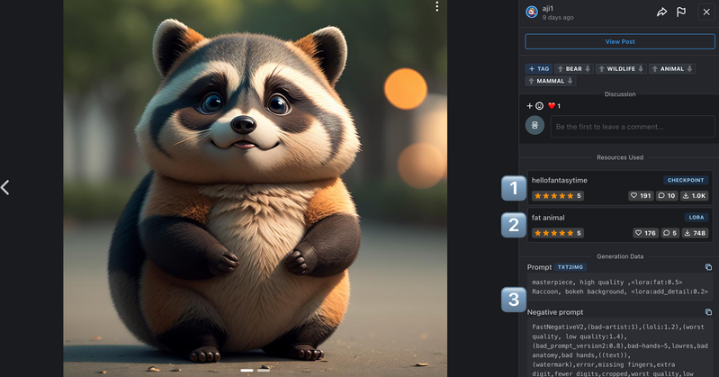

[링크](https://civitai.com/images/1623982?period=AllTime&periodMode=published&sort=Newest&view=categories&modelVersionId=119401&modelId=110738&postId=409355)의 웹페이지를 보시면 샘플 이미지를 재현하기 위한 몇 가지 조건을 확인할 수 있습니다.

1. Checkpoint : 직접 다운로드하여 파이프라인에 로드할 수 있고, huggingface 에 이미 업로드 되어있다면 해당 모델 ID 를 넣어 사용할 수 있습니다.
2. LoRA : 상대적으로 적은 용량의 파일이기 떄문에 다운로드하여 활용하겠습니다.
3. promt + negative_prompt : 상세한 프롬프트를 복사해와서 내 상황에 맞게 조금씩 변경하여 입력해줍니다.
4. 기타 조건


먼저 2 의 다운로드 링크를 통해 LoRA 파일을 `lora_example.safetensors` 라는 파일 이름으로 저장해두겠습니다.

In [ ]:
!wget https://civitai.com/api/download/models/116417 -O lora_example.safetensors

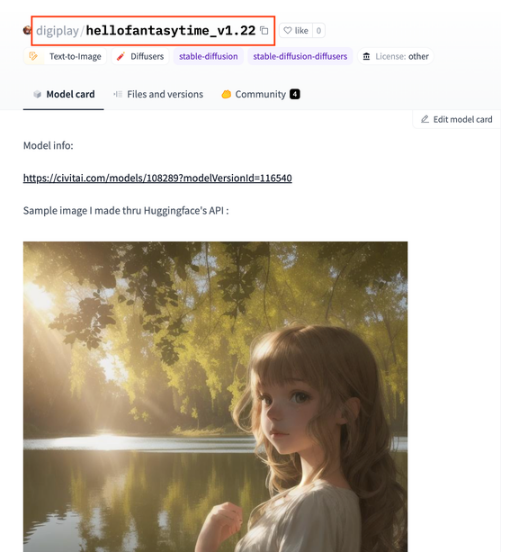

필요한 Checkpoint 는 편리하게도 huggingface 에 미리 올려진 상태입니다. 빨간 박스 부분의 이름을 복사하여 아래 코드에 넣어주겠습니다.\
프롬프트와 네거티브 프롬프트도 조금 변경하여 입력하도록 하겠습니다.

In [ ]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipeline = StableDiffusionPipeline.from_pretrained("digiplay/hellofantasytime_v1.22", torch_dtype=torch.float16)   # 알맞은 모델 ID 를 입력합니다.
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline.to("cuda")

pipeline.load_lora_weights("./lora_example.safetensors")   # 다운로드한 LoRA 를 로드합니다.

이미시 생성을 위한 모델 파이프라인이 간단하게 설정되었습니다.\
원하는 요소들을 강조하고싶다면 `prompt`에, 제거하고 싶은 요소가 있다면 `negative_prompt` 인자를 추가하여 적용할 수 있습니다.

이제 프롬프트와 다른 인자들을 알맞게 수정한 후 이미지를 출력해볼까요?

In [ ]:
image = pipeline(
    prompt="masterpiece, high quality ,<lora:fat:0.5> pink cat, in a bucket, bokeh background, <lora:add_detail:0.2>",
    negative_prompt="easynegative,(((pubic))), ((((pubic_hair)))),sketch, duplicate, ugly, huge eyes, text, logo, monochrome, worst face, (bad and mutated hands:1.3), (worst quality:2.0), (low quality:2.0), (blurry:2.0), horror, geometry, (bad hands), (missing fingers), multiple limbs, bad anatomy, (interlocked fingers:1.2), Ugly Fingers, (extra digit and hands and fingers and legs and arms:1.4), crown braid, ((2girl)), (deformed fingers:1.2), (long fingers:1.2),succubus wings,horn,succubus horn,succubus hairstyle,girl,",
    num_inference_steps=28,
    guidance_scale=7,
).images[0]

image.save("sd_lora_sample.png")
image

짠✨ 여러분은 어떤 결과물을 출력되셨나요!?

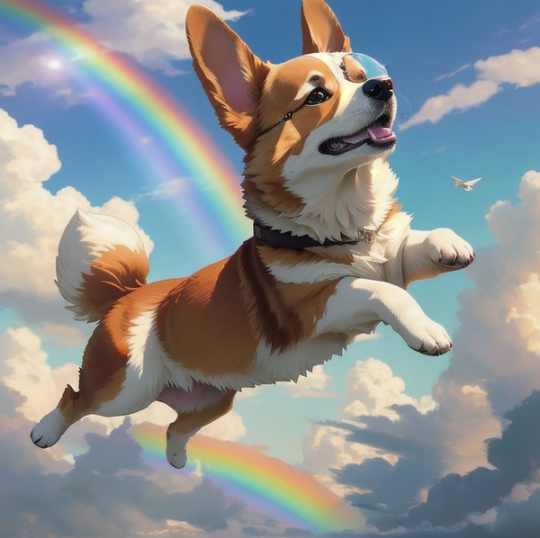